# Reparameterize Light Curve

Definitions from Winn (2011, *Exoplanets* textbook):

$$
\begin{eqnarray}
T_{14} &=& \frac{P}{\pi} \sin^{-1} \left( \frac{R_*}{a} \frac{\sqrt{1+k^2} - b^2}{\sin i}\right)\\
k &\equiv& \frac{R_p}{R_*} \\
b &\equiv& \frac{a}{R_*} \cos i
\end{eqnarray}
$$


***
Solve for $a/R_*$ and $i$ as a function of $T, b$, by solving for $a/R_*$ from both definitions of $b$ and $T$:

$$
\begin{eqnarray}
T_{14} &=& \frac{P}{\pi} \frac{R_*}{a} \frac{R_p}{R_*} \frac{1}{\sqrt{1-b^2}}\\
\frac{b}{\cos i} &=& \frac{a}{R_*} = \frac{P}{\pi} \frac{R_p}{R_*} \frac{1}{T_{14} \sqrt{1-b^2}}\\
\cos i &=& \left[ \frac{P}{\pi } \frac{R_p}{R_*} \frac{1}{T_{14}b \sqrt{1-b^2}} \right]^{-1}\\
i &=& \cos^{-1} \left[ \frac{P}{\pi } \frac{R_p}{R_*} \frac{1}{T_{14}b \sqrt{1-b^2}} \right]^{-1}
\end{eqnarray}
$$

$$
\begin{eqnarray}
 \frac{a}{R_*} = b/\cos{i}
\end{eqnarray}
$$

In [26]:
%matplotlib inline
import pyfits
import numpy as np
import matplotlib
matplotlib.rcParams['font.size'] = 15
from matplotlib import pyplot as plt
import sys
sys.path.append('../')
import photPack2
from astropy.time import Time

import sys
sys.path.append('/astro/users/bmmorris/Downloads/Fast_MA')
from ext_func.rsky import rsky
from ext_func.occultquad import occultquad

def get_lc(aRs, i, t0, q1, q2, p0, F0, e, w, period, eps, t):
    '''
    e - eccentricity
    aRs - "a over R-star"
    i - inclination angle in radians
    u1, u2 - quadratic limb-darkening coeffs
    p0 - planet to star radius ratio
    w - argument of periapse
    period - period
    t0 - midtransit (JD)
    eps - minimum eccentricity for Kepler's equation
    t - time array
    '''
    u1 = 2*np.sqrt(q1)*q2
    u2 = np.sqrt(q1)*(1 - 2*q2)
    r_s = 1.0
    npoints = len(t)
    #calculates separation of centers between the planet and the star
    z0 = rsky(e, aRs, i, r_s, w, period, t0, eps, t)   
    #returns limb darkened model lightcurve
    mu_c = occultquad(z0, u1, u2, p0, npoints)   
    return F0*mu_c

# def Tb2aRsi(P, RpRs, T, b):
#     '''
#     Convert from ingress/egress duration and impact param to a/Rs and inclination
#     '''
#     i = np.arccos( ( (P/np.pi)*RpRs/(T*b*np.sqrt(1 - b**2)) )**-1 )
#     aRs = b/np.cos(i)
#     return aRs, i

# def aRsi2Tb(P, RpRs, aRs, i):
#     '''
#     Convert from a/Rs and inclination to ingress/egress duration and impact param
#     '''
#     b = aRs*np.cos(i)
#     T = (P/np.pi)*RpRs/(aRs*np.sqrt(1-b**2))
#     return T, b

def T14b2aRsi(P, RpRs, T14, b):
    '''
    Convert from duration and impact param to a/Rs and inclination
    '''
    i = np.arccos( ( (P/np.pi)*np.sqrt(1 - b**2)/(T14*b) )**-1 )
    aRs = b/np.cos(i)
    return aRs, i

def aRsi2T14b(P, RpRs, aRs, i):
    b = aRs*np.cos(i)
    T14 = (P/np.pi)*np.sqrt(1-b**2)/aRs
    return T14, b

def reparameterized_lc(T14, b, t0, q1, q2, p0, F0, e, w, period, eps, t):
    '''
    Reparameterization of the transit light curve in `get_lc()` with
    duration (first-to-fourth contact) instead of a/R* and impact
    parameter instead of inclination
    '''
    aRs, i = T14b2aRsi(period, p0, T14, b)
    return get_lc(aRs, i, t0, q1, q2, p0, F0, e, w, period, eps, t)

#### Compare new parameterization to old:

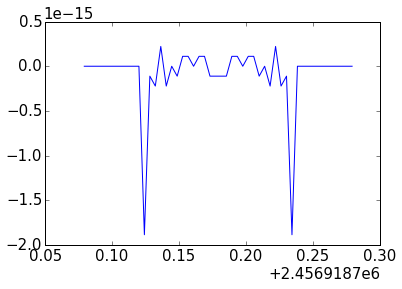

In [28]:
aOverRs = 1./0.0932 # Jord`an et al 2013
RpOverRs = 0.1404   # Jord`an et al 2013
eccentricity = 0.0 # Husnoo 2012
inclination = 88.47*np.pi/180
q1 = 0.00001
q2 = 0.2
periapse = np.pi/2 # To match e=0, from Husnoo 2012
period = 3.36100239 # Nikolov 2015          #3.361006
mineccentricity = 1.0e-7
t0_roughfit = 2456918.8793039066

n = 0.1
times = np.linspace(t0_roughfit-n, t0_roughfit+n)
old = get_lc(aOverRs, inclination, t0_roughfit, 
                       0.2, 0.2, RpOverRs, 1, eccentricity, 
                       periapse, period, 1e-7, times)

T14, b = aRsi2T14b(period, RpOverRs, aOverRs, inclination)
new = reparameterized_lc(T14, b, t0_roughfit, 
                       0.2, 0.2, RpOverRs, 1, eccentricity, 
                       periapse, period, 1e-7, times)
plt.plot(times, new-old)
plt.show()

In [13]:
allchains = np.loadtxt('/astro/store/scratch/tmp/bmmorris/longchains/mosfirespitzer/MpinkSwhite-parallel.dat')
burnin = int(0.3*allchains.shape[0])
lnp = allchains[burnin:, 1]
samples = allchains[burnin:, 2:]
print "Number of steps in chain: {0}".format(len(lnp))

Number of steps in chain: 152192


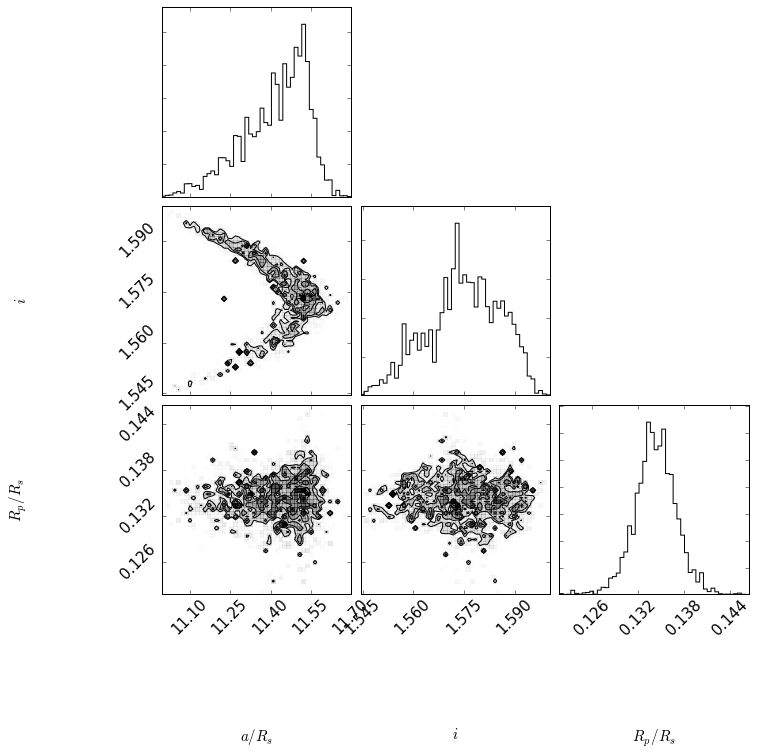

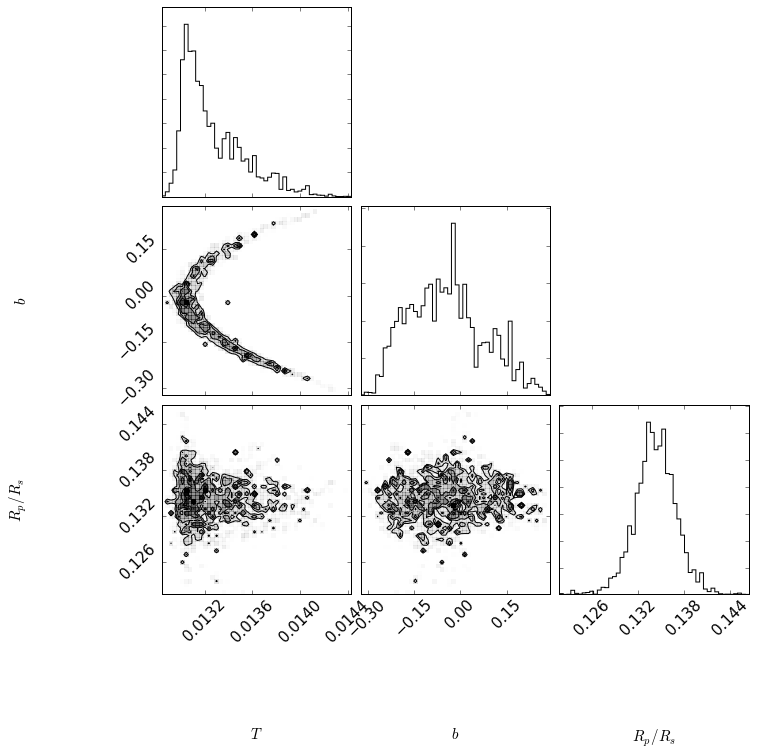

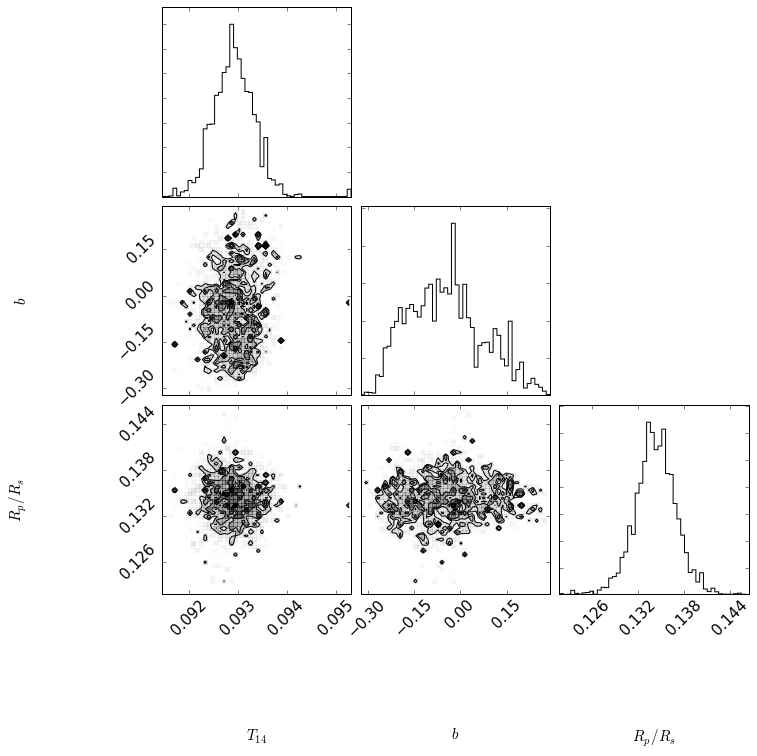

In [25]:
Nbins = 8
Nlightcurves = 10
labels = ['aRs', 'inc', 't0mos', 't0spitz'] + 2*3*['LD'] + Nlightcurves*['RpRs'] + \
         Nlightcurves*['F0'] + Nbins*['am'] + Nlightcurves*['GPw'] + Nbins*['GPamp'] + Nbins*['GPsig']

aRs = samples[:,0]
i = samples[:,1]
RpRs = samples[:,10]

import triangle
trifig, ax = plt.subplots(3, 3, figsize=(10, 10))
fig2 = triangle.corner(samples[:, [0, 1, 10]], labels=['$a/R_s$','$i$','$R_p/R_s$'], 
                       fig=trifig, plot_datapoints=False) 


T, b = aRsi2Tb(period, RpOverRs, aRs, i)

trifig, ax = plt.subplots(3, 3, figsize=(10, 10))
fig2 = triangle.corner(np.vstack([T, b, RpRs]).T, labels=['$T$','$b$','$R_p/R_s$'], 
                       fig=trifig, plot_datapoints=False) 


T14, b = aRsi2T14b(period, RpOverRs, aRs, i)
trifig, ax = plt.subplots(3, 3, figsize=(10, 10))
fig2 = triangle.corner(np.vstack([T14, b, RpRs]).T, labels=['$T_{14}$','$b$','$R_p/R_s$'], 
                       fig=trifig, plot_datapoints=False) 

plt.show()